In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

In [2]:
# Load MNIST dataset
#MNIST = k.datasets.fashion_mnist.load_data()
MNIST = k.datasets.mnist.load_data()
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 1)]
X_test = X_test[y_test.index]

# y_train[y_train==5] = 1
# y_test[y_test==5] = 1
# X_train[X_train==5] = 1
# X_test[X_test==5] = 1

print(y_train)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print()
print(y_train[y_train == 0].shape, y_train[y_train == 1].shape)
print(y_test[y_test == 0].shape, y_test[y_test == 1].shape)

1        0
3        1
6        1
8        1
14       1
        ..
59972    0
59979    1
59984    1
59987    0
59994    1
Name: training targets, Length: 12665, dtype: uint8
(12665, 28, 28) (2115, 28, 28)
(12665,) (2115,)

(5923,) (6742,)
(980,) (1135,)


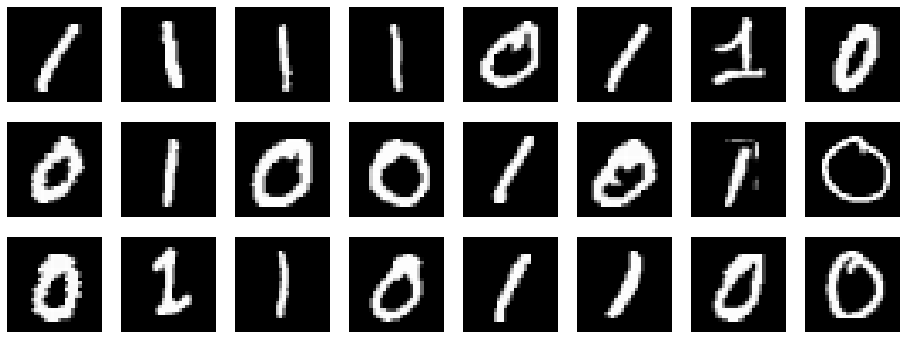

In [3]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

# Keras Model

In [137]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(28,28,1)),
    k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.MaxPooling2D((3,3)),
    #k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.Flatten(),
    k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [138]:
# Select only m samples for fast training time during debugging
m = 12000
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Compile model
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1952
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0755
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0583
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0508
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0465
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0434
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0411
Epoch 8/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0391
Epoch 9/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0371
Epoch 10/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0360


In [139]:
m = 2000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

0.983

# Custom CNN

In [4]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = tf.raw_ops.Sigmoid(x=Z).numpy()
    cache = A
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = tf.raw_ops.Relu(features=Z).numpy()
    
    cache = A
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    A = cache
    dZ = tf.raw_ops.SigmoidGrad(y=A, dy=dA).numpy()
    
    return dZ


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [10]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.05
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
        self.dZ = dZ 
        self.dW = np.dot(dZ, A_prev.T)/m
        self.db = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(self.W.T, dZ)
        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.05
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        m = A_prev.shape[0]
        self.dZ = dZ
        self.A_prev = A_prev
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()/m
        self.db = np.average(np.sum(dZ, axis=(1,2)), axis=0)
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db
        
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev

        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)

      
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = tf.raw_ops.Relu(features=Z).numpy()
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()

        return dZ
    

class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape, trainable=False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.flatten().reshape(m,np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        
    def fit(self, X, Y, epochs, learning_rate, batch_size, verbose): 
        # Initialize parameters
        history = list()
        train_dataset = tf.data.Dataset.from_tensor_slices((X, Y.T))
        train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=False)
        
        for epoch in range(epochs):
            for step, (x_batch, y_batch) in enumerate(train_dataset):
#                 print("\nBATCH SIZE", y_batch.numpy().T.shape,end="\n")
                y_batch = y_batch.numpy().T
                # FORWARD PROP
                Z = x_batch
                for layer in self.layers:    
                    if layer.__str__().split()[0] == "knn_differentiable":
                        Z = layer.forward(Z, y_batch)
                    else:
                        Z = layer.forward(Z)
                    #print(layer, Z.shape)

                # COST FUNCTION
                cost = compute_cost(Z, y_batch)
                history.append(cost)
                if verbose == 1:
                    print("Step {:.0f} in epoch {:.0f} - Cost: {:.8f}\r".format(step, epoch, cost), end="")

                # BACKWARD PROP
                dA = - (np.divide(y_batch, Z) - np.divide(1 - y_batch, 1 - Z)) # derivative of cost with respect to Z

                for layer in reversed(self.layers):
                    dA = layer.backward(dA)

                # UPDATE PARAMS
                for layer in self.layers:
                    layer.update_params(learning_rate)
            print("\n\n", "="*75, "\n")

        return history
    
    def predict(self, X, Y):
        Z = X
        for layer in self.layers:
            if layer.__str__().split()[0] == "knn_differentiable":
                Z = layer.forward(Z, Y)
            else:
                Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def _cost(self, X, Y):
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # COMPUTE COST
        return compute_cost(Z, Y)
    
    def gradcheck(self, X, Y, epsilon=1e-7, start=None, end=None):
        self.approx_grads = []
        self.true_grads = []
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self._cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self._cost(X, Y)
                layer.W[i] = Wi
                self.approx_grads.append((J1-J2)/(2*epsilon))
                
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self._cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self._cost(X, Y)
                layer.b[i] = bi
                self.approx_grads.append((J1-J2)/(2*epsilon))
        
        # FORWARD PROP
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # BACKWARD PROP
        dA = - (np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL

        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        self.approx_grads = np.array(self.approx_grads)
        self.true_grads = np.array(self.true_grads)
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))
    
        
    
class knn_differentiable(Layer):
    
    def __init__(self, input_shape, num_classes):
        super().__init__(input_shape, num_classes, False)
        
    
    def forward(self, batch_features, batch_labels):
        self.batch_features = np.transpose(batch_features).astype('float')
#         print("BATCH_FEATURES\n", self.batch_features)
#         print()
        self.batch_labels = batch_labels.astype('float')
        
        self.distances = self.calc_distance_mtx(self.batch_features, self.batch_features) * (1/100000)
        #self.distances = np.divide(1, self.distances, where=self.distances!=0)
#         print("DISTANCES\n",self.distances,self.distances.shape)
#         print()
        
        self.class_0 = np.array(self.batch_labels[:] == 0).astype('float')
        self.class_1 = np.array(self.batch_labels[:] == 1).astype('float')
        self.num_0 = np.count_nonzero(self.batch_labels == 0)
        self.num_1 = np.count_nonzero(self.batch_labels == 1)
#         print("SIZES", self.num_0, self.num_1)
#         print()

        self.aggregate = np.stack([np.sum(np.multiply(self.distances, self.class_0), 1) / self.num_0, np.sum(np.multiply(self.distances, self.class_1), 1) / self.num_1], axis=1)
#         print("AGGREGATE\n",self.aggregate,self.aggregate.shape)
#         print()
        
        exp = np.exp(-self.aggregate)
#         print("EXP OF AGGREGATE\n",exp)
#         print(exp[:,0].shape)
#         print()
        
        self.softmax = np.divide(exp[:,1], np.sum(exp, 1))
#         print("SOFTMAX\n",self.softmax[:50])
#         print("="*20)
#         print()
        
        return np.reshape(self.softmax, (1,self.distances.shape[0]))
    
    def backward(self, dA):
        # Overall what we need here:
        # d(TL)/d(X = features) = d(TL)/D(L) * d(L)/d(S) * 
        #     [(d(S)/d(A_0) * d(A_0)/d(D_0) * d(D_0)/d(X)) + (d(S)/d(A_1) * d(A_1)/d(D_1) * d(D_1)/d(X))]
        #
        # Shapes:
        # d(TL)/d(L)  -  (N x 1)           N = number of samples (images)
        # d(L)/d(S)   -  (N x 1)
        # d(S)/d(Ai)  -  (N x 1)
        # d(Ai)/d(Di) -  (N x N)
        # d(Di)/d(X)  -  (N x f)           f = number of features (output by cnn part)
        # final output:  (N x f)
        
        
        # d(TL)/d(L) = -1/m * sum(d(L)/d(S))  <-- Maybe don't need this at all, done before calling backward
        
        
        # d(L)/d(S) = (Y/S) - (1-Y)/(1-S)    <-- Y = true labels, S = softmax labels from column 0 (softmax on class 0)
        dL_dS = dA.T   # <-- Really dTL_dS
        
#         print("dL_dS", dL_dS.shape, dL_dS[:25])
#         print()
        
        
        # d(S)/d(A) = - (e^-A0 * e^-A1) / (e^-2A0 + e^-A0-A1 + e^-2A1)
        # This calc is for A_0 and A_1, A_1 is positive version of this
        #np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))
        dS_dA0 = -np.divide(np.multiply(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])), 
                            np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))).reshape(self.distances.shape[0],1)
        
        # np.add(np.add(np.exp(-2*self.aggregate[:,0]), np.exp(-2*self.aggregate[:,1])), 
        #                           np.exp(np.multiply(self.aggregate[:,0], self.aggregate[:,1])))
        
        
        dS_dA1 = -dS_dA0
#         print("dS_dA0", dS_dA0.shape, dS_dA0[:25]) (1000,) (1000,1)
#         print()
        
        
        # d(A)/d(D) = 1/len(class) * sum(d(D)/d(X))   <-- Same calc for A_0 and A_1, len(class) = how many of this class there are either num_0 or num_1
        # possibly don't need this part either since its calculated within loops???
        
        
        # d(D)/d(X) = 2(x_i - x_j)   <-- x_i and x_j are the two feature vectors used in the distance
        #distances_0 = 
        dA0_dX = np.ones(self.batch_features.shape)
        # iterate over rows in distance matrix
        for i in range(self.distances.shape[0]):
            dD_dX = np.zeros(self.batch_features.shape[1])
            # iterate over the columns in distance matrix
            for j in range(self.distances.shape[1]):
                # only calculate derivatives for indices of class 0
                if self.class_0[:,j] == 0:
                    # first calc derivative of distance formula, then them all together
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD_dX = np.add(dD_dX, deriv)
            # replace the corresponding derivatives for each row (sample)
            dA0_dX[i,:] = dD_dX
        
        # Same as loop above but on indices of class 1
        dA1_dX = np.ones(self.batch_features.shape)
        for i in range(self.distances.shape[0]):
            dD_dX = np.zeros(self.batch_features.shape[1])
            for j in range(self.distances.shape[1]):
                if self.class_0[:,j] == 1:
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD_dX = np.add(dD_dX, deriv)
            dA1_dX[i,:] = dD_dX
        

        # divide by the number of samples in each class since these were averaged in forward
        dA0_dX = dA0_dX * (1/self.num_0) * (1/100000)
        dA1_dX = dA1_dX * (1/self.num_1) * (1/100000)
#         print("dD0_dX", dD0_dX.shape, dD0_dX)
#         print()
#         print("dD1_dX", dD0_dX.shape, dD1_dX)
#         print()

        # add together the terms in brackets from the full formula
        dS_dX = np.add(np.multiply(dS_dA0, dA0_dX), np.multiply(dS_dA1, dA1_dX))
        # final step of the chain rule
        dL_dX = np.multiply(dL_dS, dS_dX)
#         print("dL_dX", dL_dX.shape, dL_dX)
        
#         print('='*50)
        return dL_dX
        #return np.zeros(self.batch_features.shape)
    
    def calc_distance_mtx(self, A, B):
        """
        Computes squared pairwise distances between each elements of A and each elements of B.
        Args:
        A,    [m,d] matrix
        B,    [n,d] matrix
        Returns:
        D,    [m,n] matrix of pairwise distances
        """
        with tf.compat.v1.variable_scope('pairwise_dist'):
            # squared norms of each row in A and B
            na = tf.reduce_sum(tf.square(A), 1)
            nb = tf.reduce_sum(tf.square(B), 1)

            # na as a row and nb as a co"lumn vectors
            na = tf.reshape(na, [-1, 1])
            nb = tf.reshape(nb, [1, -1])

            # return pairwise euclidead difference matrix
            D = tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0)
        return D.numpy()
    
    def calc_cosine_sim(self, A, B):
        from scipy.spatial.distance import pdist
        from scipy.spatial.distance import squareform
        cos_sim = squareform(pdist(A, metric='cosine'))
        return cos_sim

# Run Code below for knn layer experiments

In [11]:
# Change below three parameters for experiments 
train_size = 12665
batch_size = 512
learning = 0.0000001



times = []
accuracy_lst = [0,0,0,0]
for i in range(10):
    # Select only m samples
    m = train_size
    X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
    y = y_train[:m].values.reshape(1,m)
    # Define the layers of the model
    layers = [
        Conv2D(32, 3, (None, 28, 28, 1)),
        Maxpool((None, 26, 26, 32), pool_size=3),
        Flatten((None, 8, 8, 32)),
        knn_differentiable((2048, None), 2)
    ]

    # Create and train model
    model = Model(layers)
    start_time = time.time()
    history = model.fit(X, y, epochs=10, learning_rate=learning, verbose=1, batch_size=batch_size)
    end_time = time.time()
    ex_time = end_time-start_time
    times.append(ex_time)
    print("Execution Time:", ex_time)
    print()


    # Runs through each testing batch size for the table and gathers accuracies
    batch_sizes = [2115, 1057, batch_size, 10]
    for j in range(len(batch_sizes)):
        m = batch_sizes[j]
        n = 0
        accuracies = []
        for l in range(y_test.values.shape[0]//m):
            X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
            y = y_test[n:m].values.reshape(1,m-n).astype(float)
            predictions = model.predict(X, y)
            #print(predictions[:,:10])
            score = accuracy_score(y.flatten(), predictions.flatten().round())
            accuracies.append(score)

            n = m
            m += batch_sizes[j]

        print(accuracies)
        avg_acc = np.average(accuracies)
        accuracy_lst[j] += avg_acc
        print("Accuracy", j+1, "-", avg_acc)
        print()
    print("+"*50, "end of loop", i+1)
    print()

# Output average execution time and average accuracies in a list of the same order as shown in tables
print("\n\n\n")
print("Average Execution Time:", np.average(times), "  ---  ", "Average Accuracies:", np.divide(accuracy_lst, 10))

Step 0 in epoch 0 - Cost: 0.06487071


Step 0 in epoch 1 - Cost: 0.06487073


Step 0 in epoch 2 - Cost: 0.06487074


Step 0 in epoch 3 - Cost: 0.06487075


Step 0 in epoch 4 - Cost: 0.06487076


Step 0 in epoch 5 - Cost: 0.06487077


Step 0 in epoch 6 - Cost: 0.06487079


Step 0 in epoch 7 - Cost: 0.06487081


Step 0 in epoch 8 - Cost: 0.06487082


Step 0 in epoch 9 - Cost: 0.06487083


Execution Time: 2.791963577270508

[0.9853427895981087]
Accuracy 1 - 0.9853427895981087

[0.9848628192999054, 0.9877010406811731]
Accuracy 2 - 0.9862819299905392

[0.9853515625, 0.9892578125]
Accuracy 3 - 0.9873046875

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

Step 0 in epoch 5 - Cost: 0.02861486


Step 0 in epoch 6 - Cost: 0.02861486


Step 0 in epoch 7 - Cost: 0.02861486


Step 0 in epoch 8 - Cost: 0.02861487


Step 0 in epoch 9 - Cost: 0.02861487


Execution Time: 2.784221649169922

[0.9900709219858156]
Accuracy 1 - 0.9900709219858156

[0.988647114474929, 0.9914853358561968]
Accuracy 2 - 0.990066225165563

[0.98828125, 0.9931640625]
Accuracy 3 - 0.99072265625

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[0.9810874704491725]
Accuracy 1 - 0.9810874704491725

[0.9829706717123936, 0.9848628192999054]
Accuracy 2 - 0.9839167455061495

[0.9833984375, 0.9853515625]
Accuracy 3 - 0.984375

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

# Experiment code for fully connected layers (MNIST datasets done)

In [127]:
times = []
accuracy_lst = []
for k in range(10):
    # Select only m samples for fast training time during debugging
    #np.random.seed(10)
    m = 160
    X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
    y = y_train[:m].values.reshape(1,m)
    # Define the layers of the model
    layers = [
        Conv2D(32, 3, (None, 28, 28, 1)),
        Maxpool((None, 26, 26, 32), pool_size=2),
        Conv2D(64, 3, (None, 13, 13, 32)),
        Maxpool((None, 11, 11, 64), pool_size=2),
        Flatten((None, 5, 5, 64)),
        Dense(128, (1600, None), "relu"),
        Dense(1, (128, None), "sigmoid")
    ]

    #     k.layers.InputLayer(input_shape=(28,28,1)),
    #     k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    #     k.layers.MaxPooling2D((3,3)),
    #     k.layers.Flatten(),
    #     k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    #     k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)

    # Create and train model
    model = Model(layers)
    start_time = time.time()
    history = model.fit(X, y, epochs=10, learning_rate=0.00001, verbose=1, batch_size=32)
    end_time = time.time()
    ex_time = end_time-start_time
    times.append(ex_time)
    print("Execution Time:", ex_time)
    print()



    batch_size = 2000
    n = 0
    m = batch_size
    accuracies = []
    #print(y_test.values.shape[0]//m)
    for i in range(y_test.values.shape[0]//m):
        X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
        y = y_test[n:m].values.reshape(1,m-n).astype(float)
        predictions = model.predict(X, y)
        #print(predictions.type)
        #print(y[:,:100])
        print(predictions[:,:10])
        score = accuracy_score(y.flatten(), predictions.flatten().round())
        #print(score)
        accuracies.append(score)

        n = m
        m += batch_size
        #print(m,n)

    print(accuracies)
    avg_acc = np.average(accuracies)
    accuracy_lst.append(avg_acc)
    print("Average accuracy:", avg_acc)
    print()
    print("+"*50, "end of loop", k+1)
    print()
    
print("\n\n\n")
print("Average Execution Time:", np.average(times), "  ---  ", "Average Accuracy:", np.average(accuracy_lst))

Step 4 in epoch 0 - Cost: 7.54589347


Step 4 in epoch 1 - Cost: 3.06980805


Step 4 in epoch 2 - Cost: 1.68318198


Step 4 in epoch 3 - Cost: 0.97364412


Step 4 in epoch 4 - Cost: 1.33794635


Step 4 in epoch 5 - Cost: 1.43123341


Step 4 in epoch 6 - Cost: 0.58608754


Step 4 in epoch 7 - Cost: 1.07697159


Step 4 in epoch 8 - Cost: 0.84939766


Step 4 in epoch 9 - Cost: 0.57045606


Execution Time: 1.5428719520568848

[[0.99511791 0.92058401 0.97629122 0.9386256  0.01631713 0.99007027
  0.01573945 0.11298821 0.95109685 0.96370594]]
[0.6985]
Average accuracy: 0.6985

++++++++++++++++++++++++++++++++++++++++++++++++++ end of loop 1

Step 4 in epoch 0 - Cost: 6.941841538


Step 4 in epoch 1 - Cost: 2.58244754


Step 4 in epoch 2 - Cost: 0.70241166


Step 4 in epoch 3 - Cost: 1.02453776


Step 4 in epoch 4 - Cost: 0.43092630


Step 4 in epoch 5 - Cost: 0.51488321


Step 4 in epoch 6 - Cost: 0.72251659


Step 4 in epoch 7 - Cost: 0.50647978


Step 4 in epoch 8 - Cost: 0.77831006


Step 


Step 4 in epoch 9 - Cost: 0.72956809


Execution Time: 1.4944818019866943

[[6.53238570e-02 9.53112969e-01 8.09780479e-03 8.20338186e-01
  1.66342587e-04 9.42065276e-01 9.83923796e-01 4.65793183e-02
  8.14722464e-01 9.32741912e-01]]
[0.7825]
Average accuracy: 0.7825

++++++++++++++++++++++++++++++++++++++++++++++++++ end of loop 6

Step 4 in epoch 0 - Cost: 6.14792364


Step 4 in epoch 1 - Cost: 5.20365636


Step 4 in epoch 2 - Cost: 3.12189962


Step 4 in epoch 3 - Cost: 2.44499759


Step 4 in epoch 4 - Cost: 1.48653640


Step 4 in epoch 5 - Cost: 0.74468011


Step 4 in epoch 6 - Cost: 0.76559404


Step 4 in epoch 7 - Cost: 0.91388922


Step 4 in epoch 8 - Cost: 0.81333696


Step 4 in epoch 9 - Cost: 0.58081863


Execution Time: 1.493518590927124

[[0.99998721 0.02132199 0.97887034 0.79554984 0.00983417 0.34419039
  0.00130098 0.99157122 0.99998953 0.94681862]]
[0.7225]
Average accuracy: 0.7225

++++++++++++++++++++++++++++++++++++++++++++++++++ end of loop 7

Step 4 in epoch 0 - Cos

In [33]:
times = []
accuracy_lst = []
for k in range(10):
    # Select only m samples for fast training time during debugging
    #np.random.seed(10)
    m = 12115
    X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
    y = y_train[:m].values.reshape(1,m)
    # Define the layers of the model
    layers = [
        Conv2D(32, 3, (None, 28, 28, 1)),
        Maxpool((None, 26, 26, 32), pool_size=3),
        #Conv2D(32, 3, (None, 8, 8, 32)),
        Flatten((None, 8, 8, 32)),
        Dense(32, (2048, None), "relu"),
        Dense(1, (32, None), "sigmoid")
    ]

    #     k.layers.InputLayer(input_shape=(28,28,1)),
    #     k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    #     k.layers.MaxPooling2D((3,3)),
    #     k.layers.Flatten(),
    #     k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    #     k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)

    # Create and train model
    model = Model(layers)
    start_time = time.time()
    history = model.fit(X, y, epochs=10, learning_rate=0.0002, verbose=1, batch_size=32)
    end_time = time.time()
    ex_time = end_time-start_time
    times.append(ex_time)
    print("Execution Time:", ex_time)
    print()



    batch_size = 2115
    n = 0
    m = batch_size
    accuracies = []
    #print(y_test.values.shape[0]//m)
    for i in range(y_test.values.shape[0]//m):
        X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
        y = y_test[n:m].values.reshape(1,m-n).astype(float)
        predictions = model.predict(X, y)
        #print(predictions.type)
        #print(y[:,:100])
        print(predictions[:,:100])
        score = accuracy_score(y.flatten(), predictions.flatten().round())
        #print(score)
        accuracies.append(score)

        n = m
        m += batch_size
        #print(m,n)

    print(accuracies)
    avg_acc = np.average(accuracies)
    accuracy_lst.append(avg_acc)
    print("Average accuracy:", avg_acc)
    print()
    print("+"*50, "end of loop", k+1)
    print()
    
print("\n\n\n")
print("Average Execution Time:", np.average(times), "  ---  ", "Average Accuracy:", np.average(accuracy_lst))

Step 377 in epoch 0 - Cost: 0.01342024




KeyboardInterrupt: 